<center>
    <img src="images/personal_logo.png" style="width:50%;"/>
</center>

# Deep Unsupervised Learning - Final Project
### Juan Carlos Garzon Pico
### Viviane Alves

---

<br>

<div align="center">
  
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/Juank0621)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?logo=linkedin)](https://www.linkedin.com/in/juancarlosgarzon)
![Python](https://badges.aleen42.com/src/python.svg)

</div>

### CIFAR10 AI System

We are developing an AI system using deep learning techniques like Convolutional Autoencoders (CAE), Variational Autoencoders (VAE), and Generative Adversarial Networks (GANs) with the CIFAR10 dataset. These models will help in facial feature extraction, attribute classification, and image generation. By leveraging these approaches, we aim to enhance face recognition, noise reduction, and synthetic face generation for improved image analysis.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from PIL import Image
from tqdm import tqdm   

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision.utils import save_image
from torchsummary import summary

from sklearn.metrics import roc_curve, auc

torch.set_float32_matmul_precision('medium')

## PyTorch and GPU Information

This code snippet displays the PyTorch version, CUDA version, cuDNN version, and the number of GPUs available for PyTorch.

The first line prints the PyTorch version being used.
The second and third lines retrieve and display the CUDA and cuDNN versions used by PyTorch.
The final line shows the number of GPUs available for PyTorch, helping to confirm whether your system is utilizing the GPU for processing.
This is useful for ensuring that your environment is correctly set up to use GPU acceleration.

In [2]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.6.0+cu124


In [3]:
# Get the CUDA version used by PyTorch
cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)

# Get the cuDNN version used by PyTorch
cudnn_version = torch.backends.cudnn.version()
print("cuDNN Version:", cudnn_version)

CUDA Version: 12.4
cuDNN Version: 90100


In [4]:
# Get the number of GPUs available
num_gpus = torch.cuda.device_count()
print("Num GPUs Available:", num_gpus)

Num GPUs Available: 1


Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [5]:
!nvidia-smi

Thu Mar 20 07:47:38 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
| 30%   28C    P8              10W / 320W |    468MiB / 16376MiB |     20%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset Directory

Here we define the transformations to be applied to the images in the CIFAR10 dataset.

In [61]:
# Define transformations for the CIFAR10 dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Path to your dataset folder

In [62]:
dummy_dataset = CIFAR10(root='./data', train=True, download=True)
print(dummy_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [63]:
# Custom Dataset class for loading CIFAR10 images of a specific class
class OneClassDatasetCIFAR10(CIFAR10):
    def __init__(self, root_dir, real_class=1, transform=None, train=True, download=True):
        super().__init__(root=root_dir, transform=transform, train=train, download=download)
        self.real_class = real_class
        self.samples = []
        for i in range(len(self.data)):
            if self.targets[i] == self.real_class:
                self.samples.append((self.data[i], self.targets[i]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = self.samples[idx]
        image = Image.fromarray(data[0])  # Convertir a objeto PIL

        # Aplicar transformaciones si están definidas
        if self.transform:
            image = self.transform(image)

        label = 0  # Dummy label as autoencoder does not need labels

        return image, label

In [64]:
# Load the CIFAR10 dataset
train_dataset = CIFAR10(root='data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='data', train=False, download=True, transform=transform)

In [44]:
# # Create folders for saving images, one for each class
# for class_name in test_dataset.classes:
#     os.makedirs(f'./cifar10_test_images/{class_name}', exist_ok=True)

# # Save the test images to the appropriate folders
# for idx, (img, label) in enumerate(test_dataset):
#     class_name = test_dataset.classes[label]  # Get the class name for the image
#     save_image(img, f'./cifar10_test_images/{class_name}/{idx}.png')  # Save each image as PNG

# print("Test images saved in './cifar10_test_images/'")

In [45]:
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [46]:
# Verify the number of images in each dataset
print(f'Number of images in training dataset: {len(train_dataset)}')
print(f'Number of images in validation dataset: {len(val_dataset)}')
print(f'Number of images in test dataset: {len(test_dataset)}')

Number of images in training dataset: 40000
Number of images in validation dataset: 10000
Number of images in test dataset: 10000


In [47]:
# Create data loaders for the training, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [48]:
# Function to show images from the CIFAR10 dataset
def show_transform_images(loader):
    data_iter = iter(loader)
    images, _ = next(data_iter)
    images = images.numpy()
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(2):
        for j in range(5):
            ax = axes[i, j]
            ax.imshow(np.transpose(images[i * 5 + j], (1, 2, 0)))
            # Set the axis labels and ticks as proportional
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6..0.77254903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.37254906].
Cl

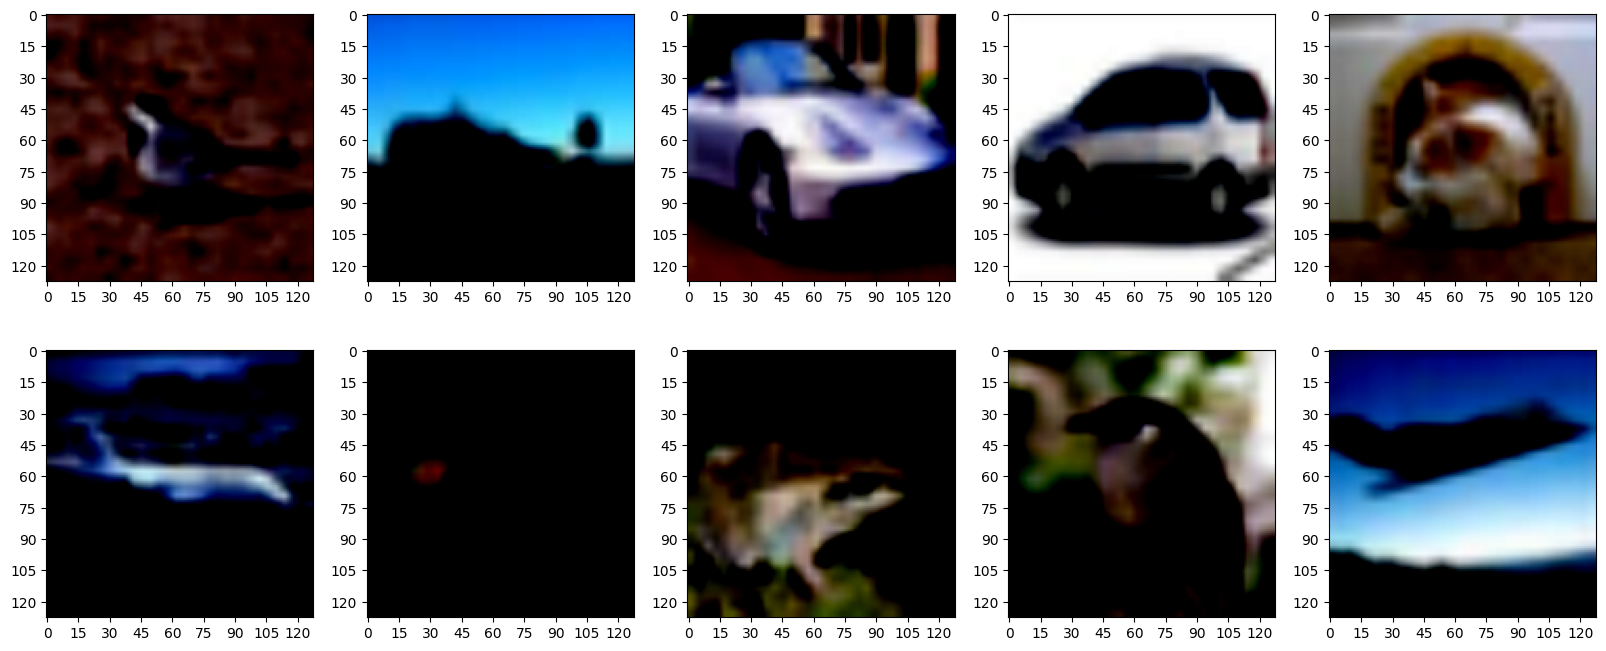

In [49]:
# Show images from the CelebA dataset
show_transform_images(train_loader)

## Vanilla AutoEncoder

### Define the Vanilla Autoencoder Model

In [50]:
# The latent_dim variable defines the size of the latent space.
latent_dim = 512

In [51]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 128x128 → 64x64
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 64x64 → 32x32
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 32x32 → 16x16
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 16x16 → 8x8
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 8x8 → 4x4
            
            nn.Flatten(),  # Flatten to a 1D vector
            nn.Linear(4 * 4 * 512, latent_dim),  # Match the output to the latent dimension
            nn.SiLU()
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 512),
            nn.SiLU(),
            nn.Unflatten(1, (512, 4, 4)),

            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 → 8x8
            nn.BatchNorm2d(256),
            nn.SiLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 → 16x16
            nn.BatchNorm2d(128),
            nn.SiLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 → 32x32
            nn.BatchNorm2d(64),
            nn.SiLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 → 64x64
            nn.BatchNorm2d(32),
            nn.SiLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 → 128x128
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class VanillaAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VanillaAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [52]:
vanilla_autoencoder = VanillaAutoencoder(latent_dim)

In [53]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vanilla_autoencoder.to(device)

VanillaAutoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): SiLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): SiLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(256, eps

In [54]:
summary(vanilla_autoencoder, input_size=(3, 128, 128)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              SiLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             SiLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
      BatchNorm2d-14          [-1, 256,

### Train Vanilla Autoencoder

We train the vanilla autoencoder for 20 epochs.

In [55]:
# Function to train the model for one epoch
def train_epoch(vanilla_autoencoder, train_loader, criterion, optimizer):
    vanilla_autoencoder.train()
    total_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = vanilla_autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Function to evaluate the model
def evaluate_model(vanilla_autoencoder, val_loader, criterion):
    vanilla_autoencoder.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            outputs = vanilla_autoencoder(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Function to test the model and calculate AUROC
def test_model(vanilla_autoencoder, real_test_loader, ano_test_loaders):
    vanilla_autoencoder.eval()

    def get_score(loader):
        log_probs = []
        with torch.no_grad():
            for inputs, _ in loader:
                inputs = inputs.to(device)
                outputs = vanilla_autoencoder(inputs)
                mse_loss = F.mse_loss(outputs, inputs, reduction='none').mean(dim=[1, 2, 3])
                log_probs.append(mse_loss.cpu().numpy())
        return np.concatenate(log_probs)

    real_log_probs = get_score(real_test_loader)
    ano_log_probs = [get_score(loader) for loader in ano_test_loaders]
    aurocs = []
    for ano_log_prob in ano_log_probs:
        y_true = np.concatenate([np.ones_like(real_log_probs), np.zeros_like(ano_log_prob)])
        y_score = np.concatenate([real_log_probs, ano_log_prob])
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        aurocs.append(roc_auc)

    return np.mean(aurocs)

# Function to select the threshold
def select_threshold(vanilla_autoencoder, real_test_loader, ano_test_loader):
    vanilla_autoencoder.eval()

    def get_score(loader):
        log_probs = []
        with torch.no_grad():
            for inputs, _ in loader:
                inputs = inputs.to(device)
                outputs = vanilla_autoencoder(inputs)
                mse_loss = F.mse_loss(outputs, inputs, reduction='none').mean(dim=[1, 2, 3])
                log_probs.append(mse_loss.cpu().numpy())
        return np.concatenate(log_probs)

    real_log_probs = get_score(real_test_loader)
    ano_log_probs = get_score(ano_test_loader)
    y_true = np.concatenate([np.ones_like(real_log_probs), np.zeros_like(ano_log_probs)])
    y_score = np.concatenate([real_log_probs, ano_log_probs])

    thresholds = np.linspace(0.001, 0.99, 10)
    best_threshold = 0
    best_accuracy = 0
    for threshold in thresholds:
        binary_score = y_score >= threshold
        correct = (binary_score == y_true).sum().item()
        acc = correct / len(y_true)
        if acc > best_accuracy:
            best_accuracy = acc
            best_threshold = threshold

    return best_threshold

In [56]:
def save_weights(model, path):
    torch.save(model.state_dict(), path)

In [ ]:
# Main function to train and evaluate the model
def main():
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize confusion matrix and lists to store results
    confusion_mat = np.zeros((10, 10))
    all_aurocs = []
    all_thresholds = []
    all_train_losses = []
    all_val_losses = []

    # Loop over each class as the real class
    for real_class in range(10):
        print(f'Training for real class: {real_class}')

        # Load datasets
        train_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=True, download=True)
        val_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=False, download=True)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        real_test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        ano_test_loaders = [DataLoader(OneClassDatasetCIFAR10(root_dir='data', real_class=i, transform=transform, train=False, download=True), batch_size=32, shuffle=False) for i in range(10) if i != real_class]

        # Initialize model, criterion, and optimizer
        vanilla_autoencoder = VanillaAutoencoder(latent_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(vanilla_autoencoder.parameters(), lr=0.0005)

        # Training loop
        num_epochs = 30
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            train_loss = train_epoch(vanilla_autoencoder, train_loader, criterion, optimizer)
            val_loss = evaluate_model(vanilla_autoencoder, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Store losses
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Calculate AUROC
        auroc = test_model(vanilla_autoencoder, real_test_loader, ano_test_loaders)
        all_aurocs.append(auroc)
        print(f'AUROC for class {real_class}: {auroc:.4f}')

        # Select threshold
        threshold = select_threshold(vanilla_autoencoder, real_test_loader, ano_test_loaders[0])
        all_thresholds.append(threshold)
        print(f'Selected Threshold for class {real_class}: {threshold:.4f}')

        # Update confusion matrix
        def get_predictions(loader, threshold):
            predictions = []
            with torch.no_grad():
                for inputs, _ in loader:
                    inputs = inputs.to(device)
                    outputs = vanilla_autoencoder(inputs)
                    mse_loss = F.mse_loss(outputs, inputs, reduction='none').mean(dim=[1, 2, 3])
                    preds = (mse_loss < threshold).cpu().numpy()
                    predictions.append(preds)
            return np.concatenate(predictions)

        real_preds = get_predictions(real_test_loader, threshold)
        for i, ano_loader in enumerate(ano_test_loaders):
            ano_preds = get_predictions(ano_loader, threshold)
            confusion_mat[real_class, real_class] += np.sum(real_preds == 1)
            confusion_mat[real_class, i if i < real_class else i + 1] += np.sum(ano_preds == 0)

        # Save the model weights after training for each class
        save_weights(vanilla_autoencoder, f'models/vanilla_autoencoder/vanilla_autoencoder_class_{real_class}_weights.pth')

    return confusion_mat, all_aurocs, all_thresholds, all_train_losses, all_val_losses

In [58]:
# Call the main function and get results
# confusion_mat, all_aurocs, all_thresholds, all_train_losses, all_val_losses = main()

Training for real class: 0
Epoch 1/30, Train Loss: 0.2843, Val Loss: 0.1755
Epoch 2/30, Train Loss: 0.1713, Val Loss: 0.1370
Epoch 3/30, Train Loss: 0.1415, Val Loss: 0.1236
Epoch 4/30, Train Loss: 0.1275, Val Loss: 0.1144
Epoch 5/30, Train Loss: 0.1178, Val Loss: 0.1050
Epoch 6/30, Train Loss: 0.1119, Val Loss: 0.1011
Epoch 7/30, Train Loss: 0.1080, Val Loss: 0.0970
Epoch 8/30, Train Loss: 0.1054, Val Loss: 0.0972
Epoch 9/30, Train Loss: 0.1035, Val Loss: 0.0963
Epoch 10/30, Train Loss: 0.1029, Val Loss: 0.0945
Epoch 11/30, Train Loss: 0.1016, Val Loss: 0.1002
Epoch 12/30, Train Loss: 0.1020, Val Loss: 0.0923
Epoch 13/30, Train Loss: 0.1001, Val Loss: 0.0912
Epoch 14/30, Train Loss: 0.0990, Val Loss: 0.0906
Epoch 15/30, Train Loss: 0.0986, Val Loss: 0.0926
Epoch 16/30, Train Loss: 0.0984, Val Loss: 0.0901
Epoch 17/30, Train Loss: 0.0975, Val Loss: 0.0911
Epoch 18/30, Train Loss: 0.0968, Val Loss: 0.0905
Epoch 19/30, Train Loss: 0.0972, Val Loss: 0.0900
Epoch 20/30, Train Loss: 0.0962,

In [72]:
# Función para graficar las pérdidas
def plot_losses(train_losses, val_losses, class_index):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for Class {class_index}')
    plt.legend()
    plt.show()

# Función para graficar la matriz de confusión
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Función para graficar AUROC y umbrales
def plot_auroc_thresholds(aurocs, thresholds):
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), aurocs, alpha=0.6, label='AUROC')
    plt.plot(range(10), thresholds, marker='o', linestyle='--', color='red', label='Threshold')
    plt.xlabel('Class')
    plt.ylabel('Value')
    plt.title('AUROC and Thresholds for Each Class')
    plt.legend()
    plt.show()

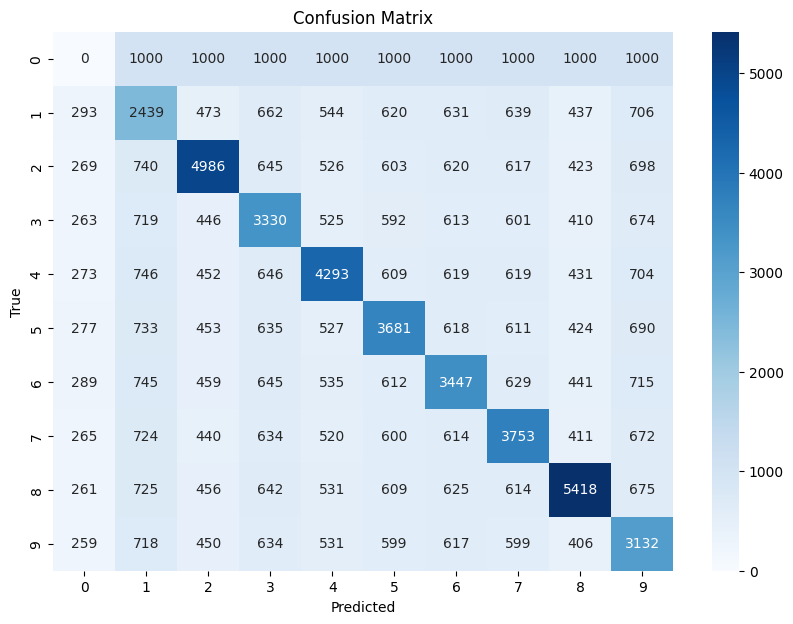

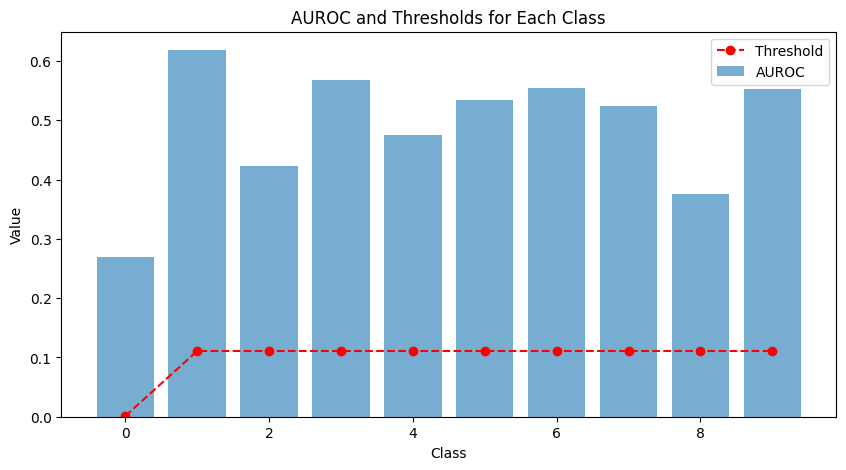

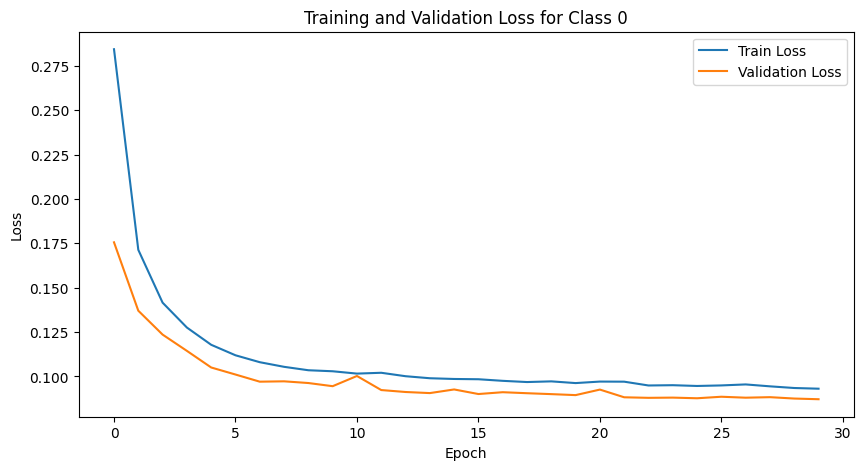

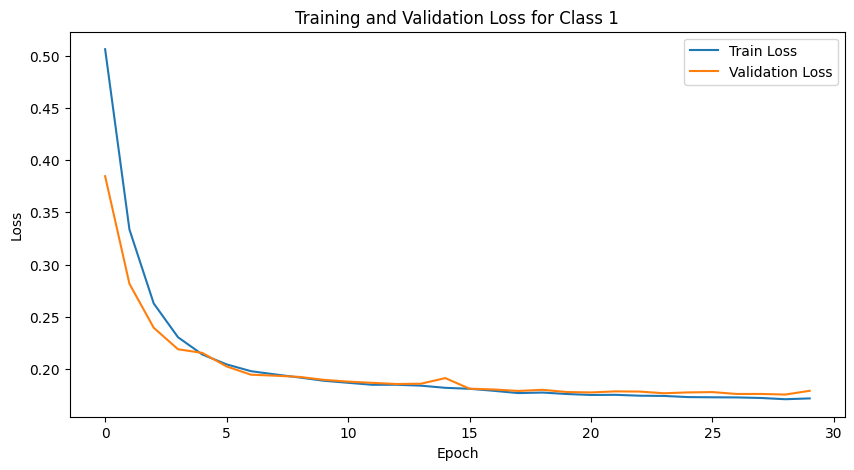

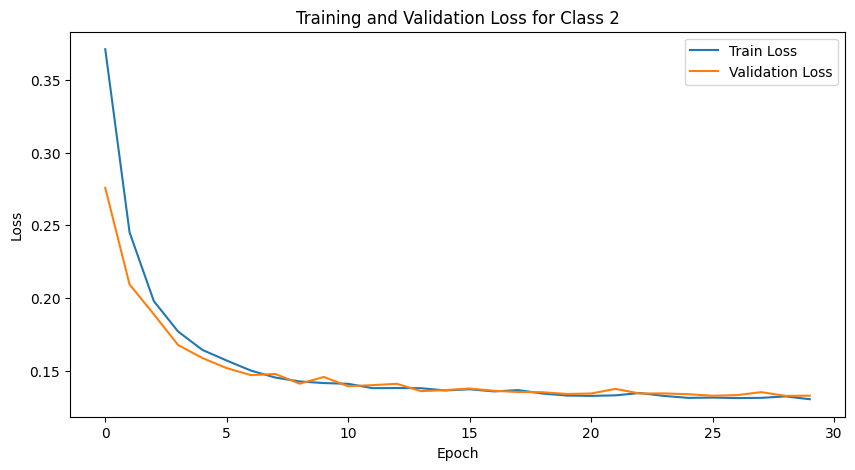

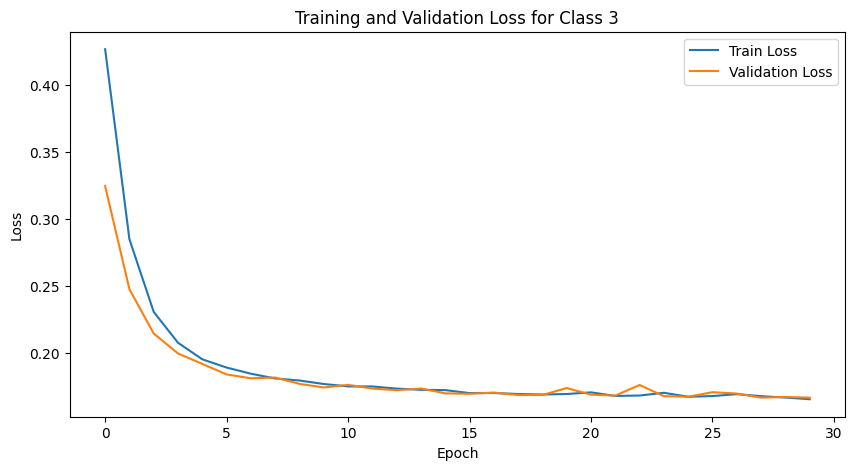

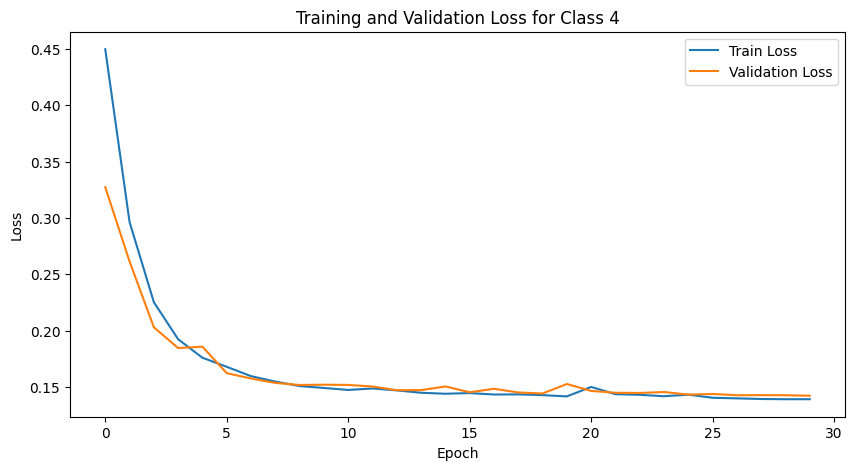

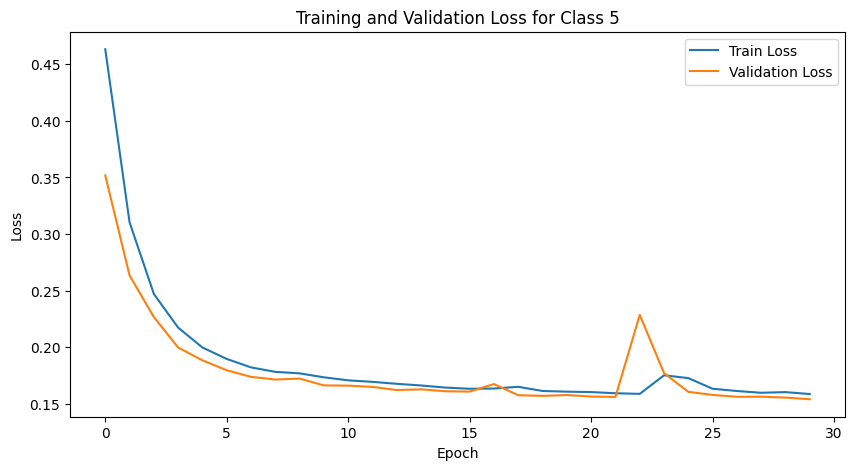

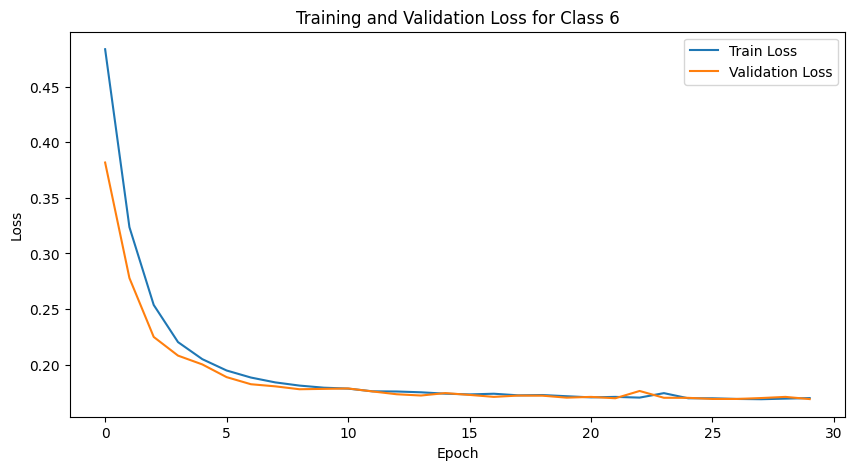

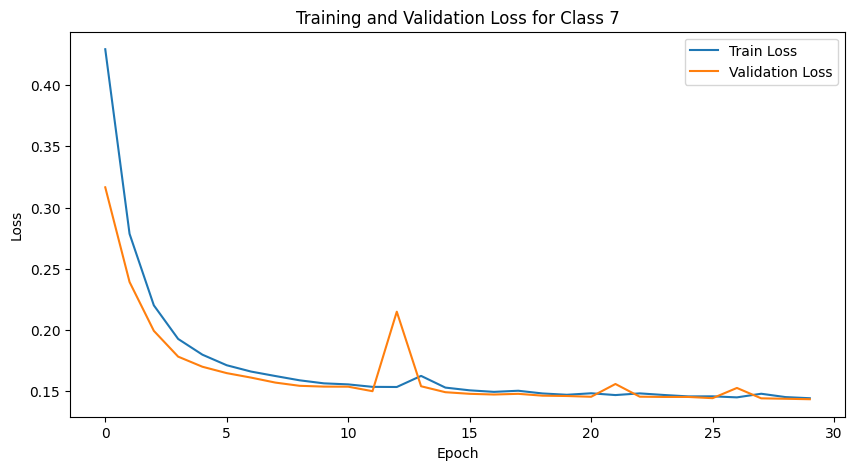

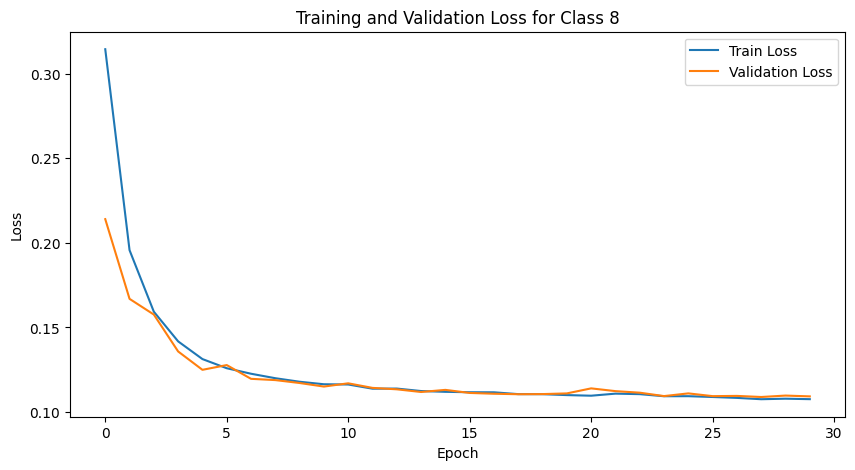

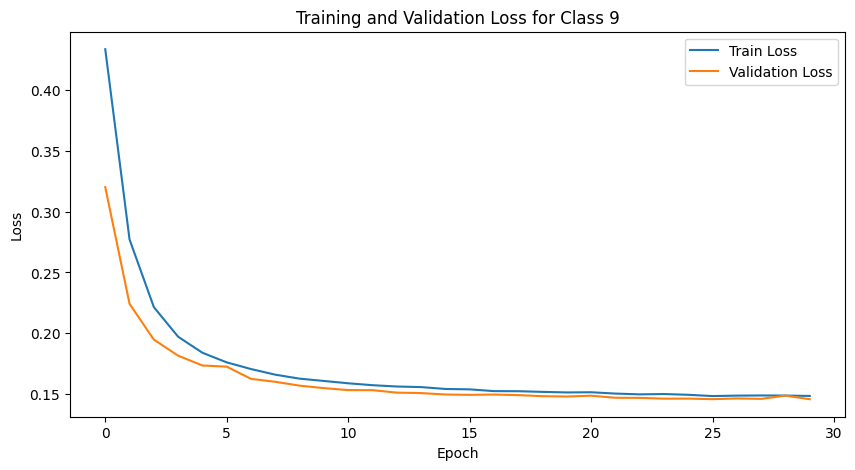

In [73]:
# Plot confusion matrix
plot_confusion_matrix(confusion_mat)

# Plot AUROC and thresholds
plot_auroc_thresholds(all_aurocs, all_thresholds)

# Plot losses for each class
for real_class in range(10):
    plot_losses(all_train_losses[real_class], all_val_losses[real_class], real_class)

In [80]:
def load_weights(model, path):
    model.load_state_dict(torch.load(path)) # Load the saved model weights
    model.eval()  # Important: Set the model to evaluation mode

In [83]:
# Function to display 5 original and reconstructed images from the test dataset
def compare_images(test_loader):
    images, reconstructed_images = [], []
    for class_index in range(10):
        # Load the model for the specific class
        vanilla_autoencoder = VanillaAutoencoder(latent_dim).to(device)
        load_weights(vanilla_autoencoder, f'models/vanilla_autoencoder/vanilla_autoencoder_class_{class_index}_weights.pth')
        vanilla_autoencoder.eval()
        
        with torch.no_grad():
            for i, (inputs, _) in enumerate(test_loader):
                if i >= 5:
                    break
                inputs = inputs.to(device)
                outputs = vanilla_autoencoder(inputs)
                images.append(inputs[0].cpu())  # toma solo la primera imagen del batch
                reconstructed_images.append(outputs[0].cpu())  # toma solo la primera imagen reconstruida
                break  # solo quieres una imagen por clase

    fig, axs = plt.subplots(5, 2, figsize=(10, 20))
    for i in range(5):
        axs[i, 0].imshow(images[i].permute(1, 2, 0).numpy())
        axs[i, 0].set_title("Original")
        axs[i, 0].axis("off")
        axs[i, 1].imshow(reconstructed_images[i].permute(1, 2, 0).numpy())
        axs[i, 1].set_title(f"Reconstructed (Class {i})")
        axs[i, 1].axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.9843137].


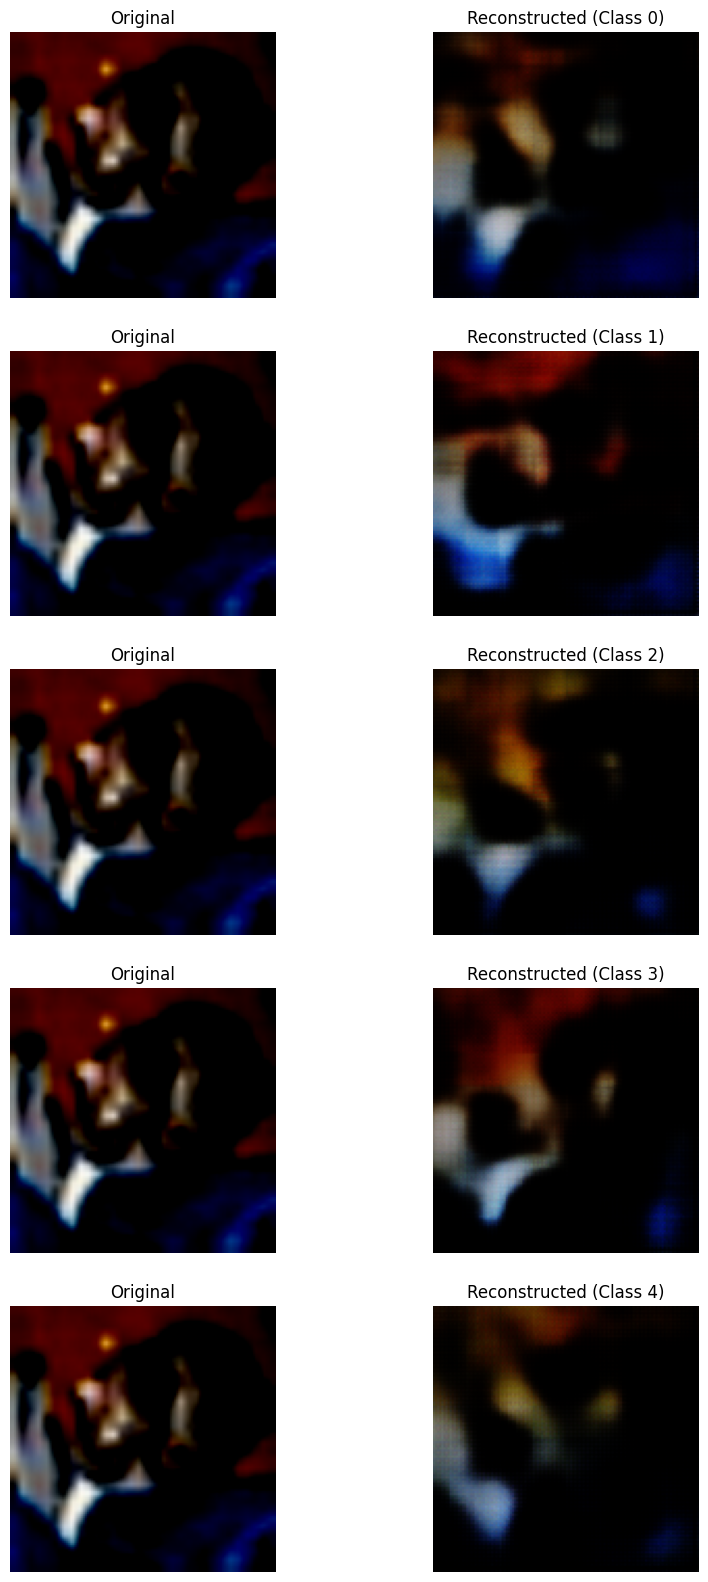

In [84]:
# Display 5 original and reconstructed images from the test dataset using different models for each class
compare_images(test_loader)

## Denoising AutoEncoder

### Function to add noise to images

This function adds Gaussian noise to the input images.

In [85]:
# Function to add noise to images
def add_noise(img):
    noise = torch.randn_like(img) * 0.1
    img_noisy = torch.clamp(img + noise, 0., 1.)
    return img_noisy

# Function to train the denoising autoencoder for one epoch
def train_denoising_epoch(denoising_autoencoder, train_loader, criterion, optimizer):
    denoising_autoencoder.train()
    total_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        inputs_noisy = add_noise(inputs)
        optimizer.zero_grad()
        outputs = denoising_autoencoder(inputs_noisy)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

### Train Denoising Autoencoder

We train the denoising autoencoder for 20 epochs.

In [86]:
# Main function to train and evaluate the denoising autoencoder model
def main_denoising():
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize confusion matrix and lists to store results
    confusion_mat = np.zeros((10, 10))
    all_aurocs = []
    all_thresholds = []
    all_train_losses = []
    all_val_losses = []

    # Loop over each class as the real class
    for real_class in range(10):
        print(f'Training for real class: {real_class}')

        # Load datasets
        train_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=True, download=True)
        val_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=False, download=True)

        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

        real_test_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
        ano_test_loaders = [DataLoader(OneClassDatasetCIFAR10(root_dir='data', real_class=i, transform=transform, train=False, download=True), batch_size=32, shuffle=False) for i in range(10) if i != real_class]

        # Initialize model, criterion, and optimizer
        denoising_autoencoder = VanillaAutoencoder(latent_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(denoising_autoencoder.parameters(), lr=0.0005)

        # Training loop
        num_epochs = 20
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            train_loss = train_denoising_epoch(denoising_autoencoder, train_loader, criterion, optimizer)
            val_loss = evaluate_model(denoising_autoencoder, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Store losses
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Calculate AUROC
        auroc = test_model(denoising_autoencoder, real_test_loader, ano_test_loaders)
        all_aurocs.append(auroc)
        print(f'AUROC for class {real_class}: {auroc:.4f}')

        # Select threshold
        threshold = select_threshold(denoising_autoencoder, real_test_loader, ano_test_loaders[0])
        all_thresholds.append(threshold)
        print(f'Selected Threshold for class {real_class}: {threshold:.4f}')

        # Update confusion matrix
        def get_predictions(loader, threshold):
            predictions = []
            with torch.no_grad():
                for inputs, _ in loader:
                    inputs = inputs.to(device)
                    outputs = denoising_autoencoder(inputs)
                    mse_loss = F.mse_loss(outputs, inputs, reduction='none').mean(dim=[1, 2, 3])
                    preds = (mse_loss < threshold).cpu().numpy()
                    predictions.append(preds)
            return np.concatenate(predictions)

        real_preds = get_predictions(real_test_loader, threshold)
        for i, ano_loader in enumerate(ano_test_loaders):
            ano_preds = get_predictions(ano_loader, threshold)
            confusion_mat[real_class, real_class] += np.sum(real_preds == 1)
            confusion_mat[real_class, i if i < real_class else i + 1] += np.sum(ano_preds == 0)

        # Save the model weights after training for each class
        save_weights(denoising_autoencoder, f'models/denoising_autoencoder/denoising_autoencoder_class_{real_class}_weights.pth')

    return confusion_mat, all_aurocs, all_thresholds, all_train_losses, all_val_losses

In [88]:
# Call the main function for denoising autoencoder and get results
confusion_mat, all_aurocs, all_thresholds, all_train_losses, all_val_losses = main_denoising()

Training for real class: 0
Epoch 1/20, Train Loss: 0.3285, Val Loss: 0.2140
Epoch 2/20, Train Loss: 0.2370, Val Loss: 0.2069
Epoch 3/20, Train Loss: 0.1937, Val Loss: 0.2016
Epoch 4/20, Train Loss: 0.1687, Val Loss: 0.1731
Epoch 5/20, Train Loss: 0.1503, Val Loss: 0.1554
Epoch 6/20, Train Loss: 0.1383, Val Loss: 0.1469
Epoch 7/20, Train Loss: 0.1302, Val Loss: 0.1287
Epoch 8/20, Train Loss: 0.1231, Val Loss: 0.1277
Epoch 9/20, Train Loss: 0.1182, Val Loss: 0.1264
Epoch 10/20, Train Loss: 0.1162, Val Loss: 0.1185
Epoch 11/20, Train Loss: 0.1112, Val Loss: 0.1169
Epoch 12/20, Train Loss: 0.1096, Val Loss: 0.1147
Epoch 13/20, Train Loss: 0.1067, Val Loss: 0.1221
Epoch 14/20, Train Loss: 0.1051, Val Loss: 0.1221
Epoch 15/20, Train Loss: 0.1046, Val Loss: 0.1245
Epoch 16/20, Train Loss: 0.1056, Val Loss: 0.1178
Epoch 17/20, Train Loss: 0.1030, Val Loss: 0.1226
Epoch 18/20, Train Loss: 0.1011, Val Loss: 0.1235
Epoch 19/20, Train Loss: 0.1017, Val Loss: 0.1779
Epoch 20/20, Train Loss: 0.1030,

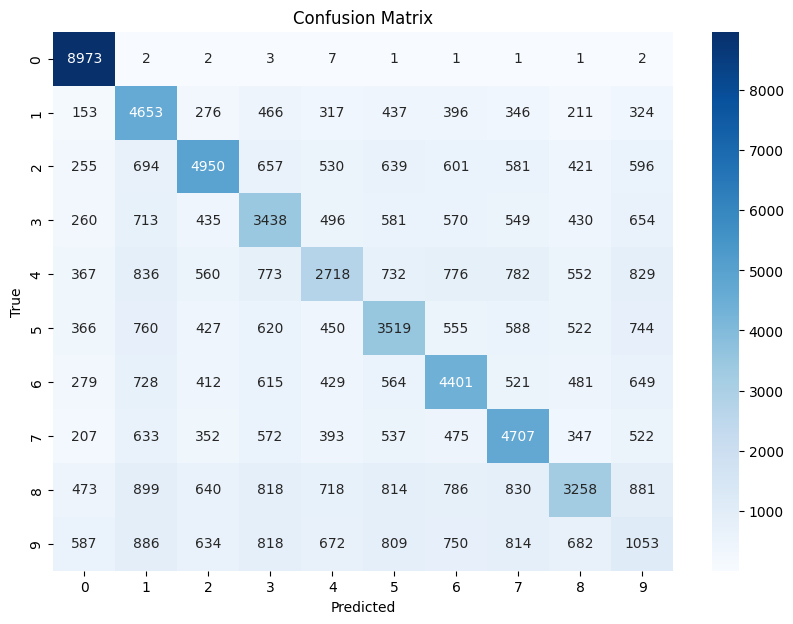

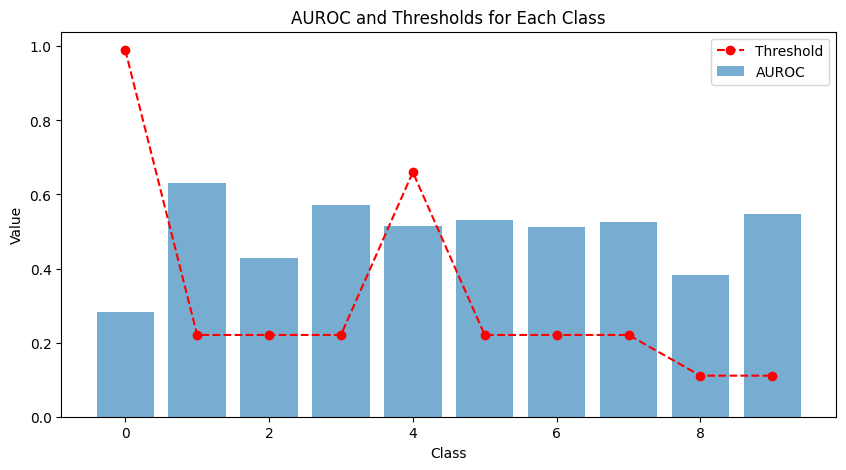

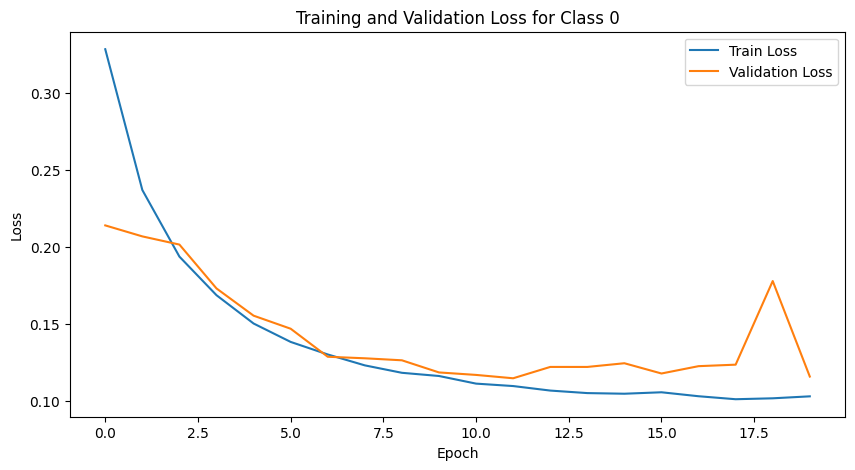

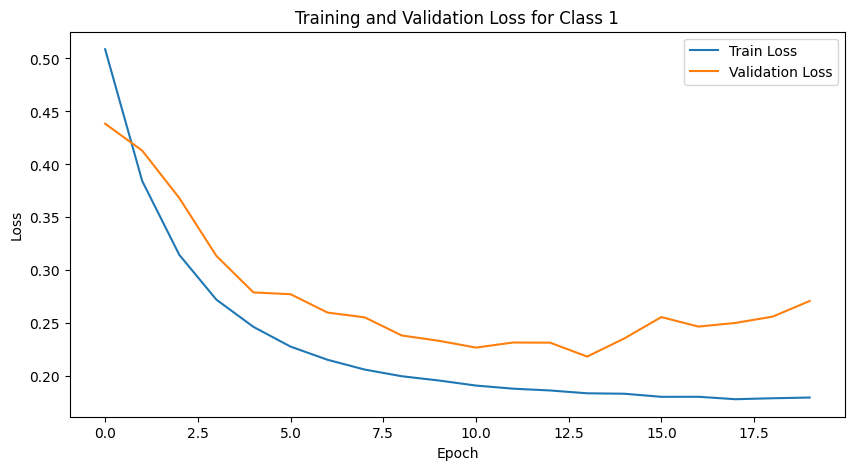

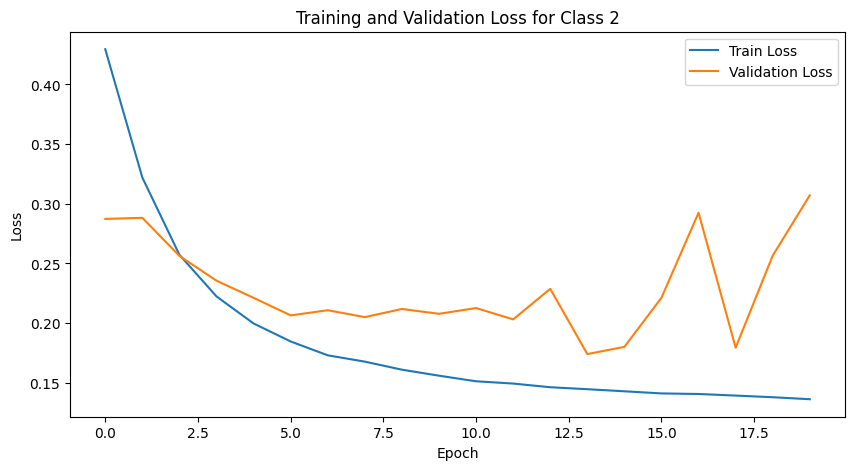

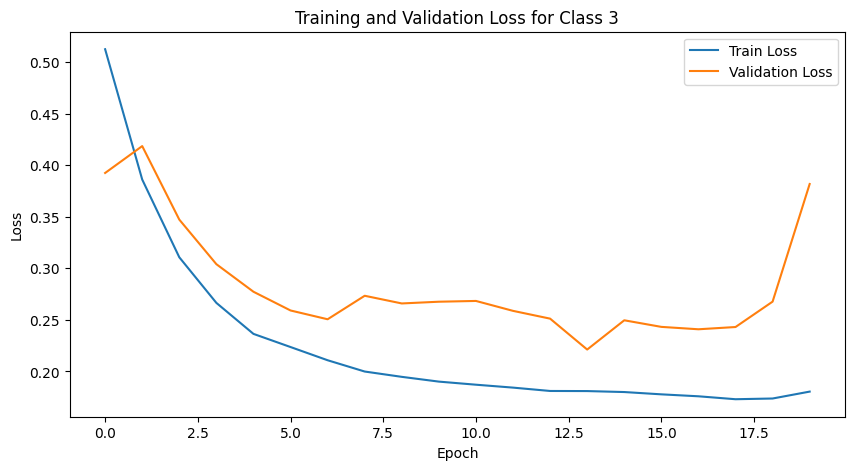

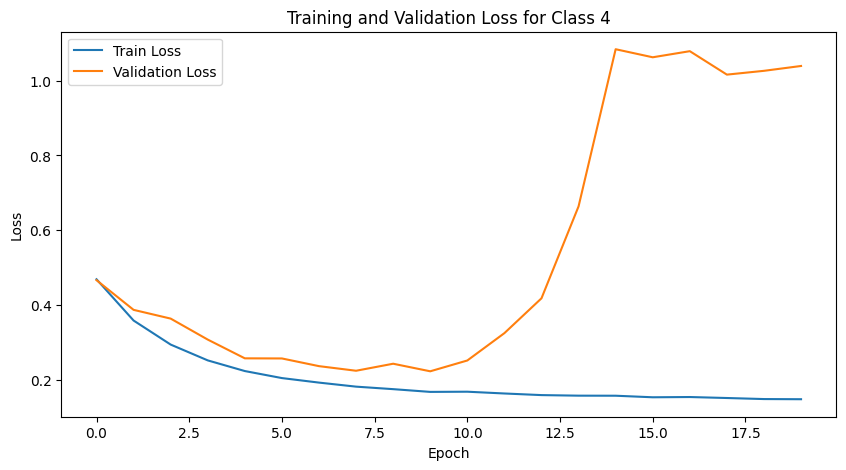

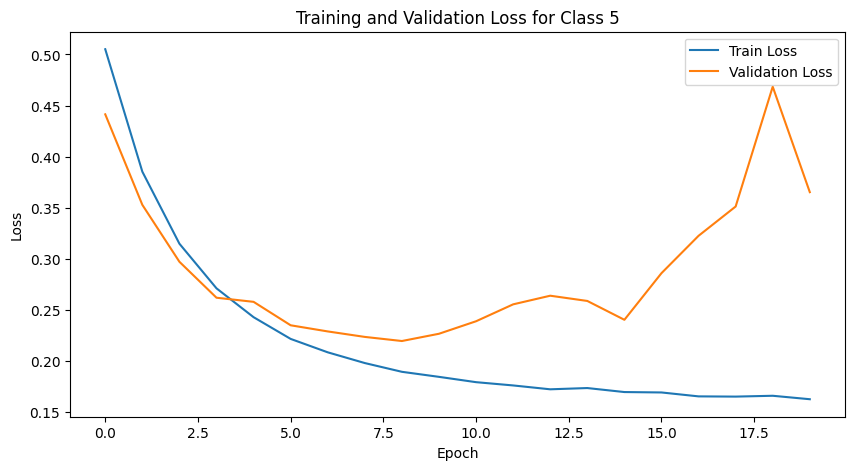

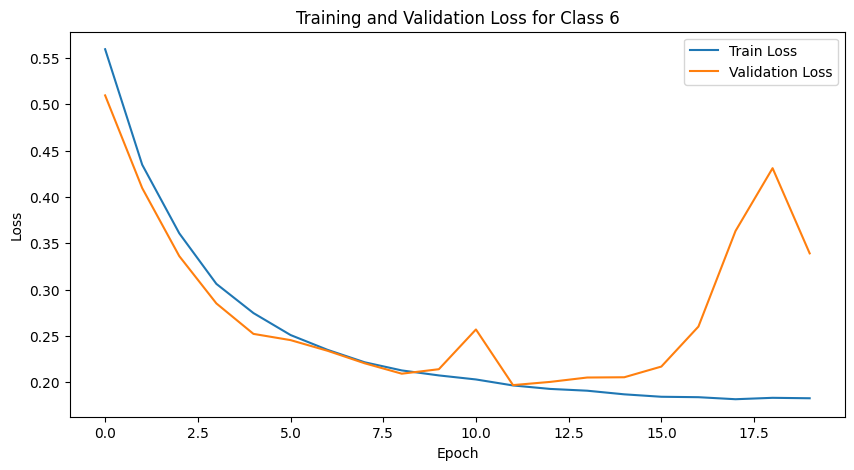

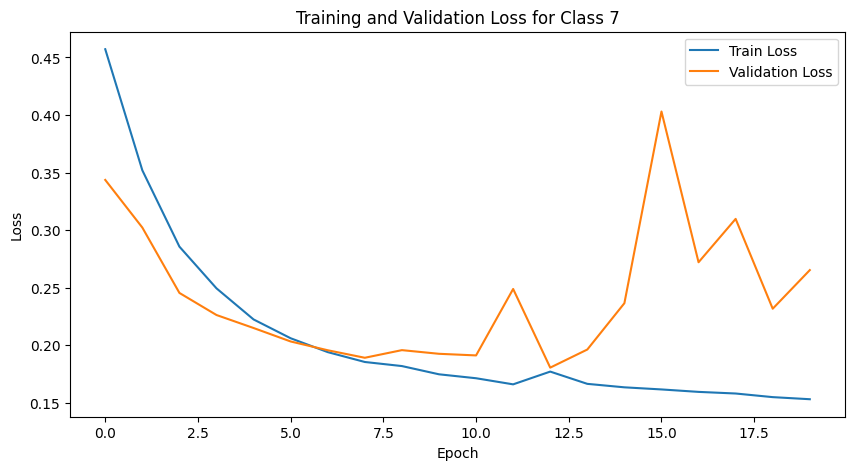

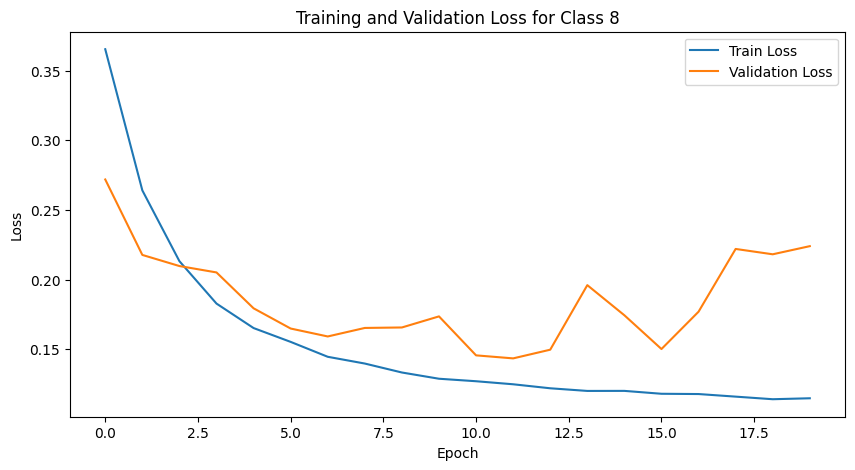

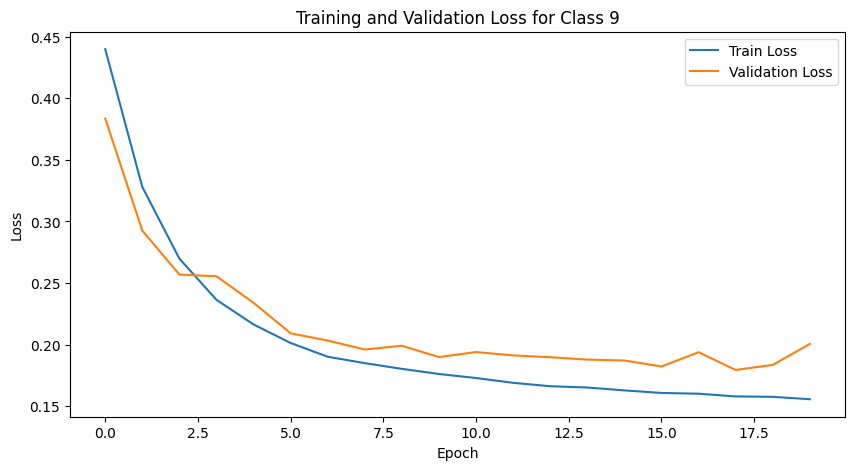

In [89]:
# Plot confusion matrix
plot_confusion_matrix(confusion_mat)

# Plot AUROC and thresholds
plot_auroc_thresholds(all_aurocs, all_thresholds)

# Plot losses for each class
for real_class in range(10):
    plot_losses(all_train_losses[real_class], all_val_losses[real_class], real_class)

In [ ]:
def load_weights(model, path):
    model.load_state_dict(torch.load(path)) # Load the saved model weights
    model.eval()  # Important: Set the model to evaluation mode

Model loaded and ready to use.


## Variational autoencoder (VAE)

## Generative Adversarial Network (GAN)

## Citation

```bibtex
@techreport{krizhevsky2009learning,
  title = {Learning Multiple Layers of Features from Tiny Images},
  author = {Alex Krizhevsky},
  institution = {University of Toronto},
  year = {2009},
  url = {https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf}
}